## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [1]:
# Install libraries the first time
# !pip install -q ipynb yfinance pandas pathlib numpy

### Importing Required Libraries

In [2]:
from fastai.tabular.all import *
from fastai.tabular.all import TabularPandas
import yfinance as yf
import pandas as pd
import pathlib
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from fastai.metrics import rmse, mae
import os

### Global Variables

In [3]:
# Model settings
modelName = 'stockScreenerV8.0'
trainingData = 'stockData.csv'
getNewData = True 
trainNewModel = True
predictionTarget = 'NVO'  # 'ALL' for all tickers, 'None' for no prediction

# Training parameters
trainingSize = 30  # Number of stocks to use for training
timeFrame = 'max'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
catNames = ['Date']
contNames = ['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'EV/EBIT', 'ROIC']
epochs = 20

# Testing parameters
testSize = 175  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Remove Duplicate Tickers

In [4]:
df = pd.read_csv(testFolder / 'tickers.csv')
df.drop_duplicates().to_csv(testFolder / 'tickers.csv', index=False)

#### Utility Functions

In [5]:
def getIndustry(tickerSymbol):
    """Fetches the industry of the given ticker symbol."""
    try:
        return yf.Ticker(tickerSymbol).info.get('industry', 'Unknown')
    except Exception as e:
        return 'Error'

In [6]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    valid_periods = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
    try:
        if timeframe == 'max':
            future_change = yf.Ticker(ticker_symbol).history(period='max')
            future_change['Future Year Change'] = (future_change['Close'].shift(-252) / future_change['Close'] - 1)
            future_change = future_change.dropna(subset=['Future Year Change'])
        else:
            # Calculate the extended timeframe
            extended_timeframe = valid_periods[min(valid_periods.index(timeframe) + buffer, len(valid_periods) - 1)]
            future_change = yf.Ticker(ticker_symbol).history(period=extended_timeframe)
            future_change['Future Year Change'] = (future_change['Close'].shift(-252) / future_change['Close'] - 1)

            # Calculate the end date and start date based on the timeframe
            end_date = future_change.index[-1] - pd.DateOffset(years=1)
            start_date = end_date - pd.DateOffset(years=int(timeframe[:-1]))
            future_change = future_change.loc[start_date:end_date].dropna(subset=['Future Year Change'])
        return future_change
    except Exception as e:
        return pd.DataFrame()

In [7]:
def getEVComponents(tickerSymbol):
    """Fetches static EV components (total debt, cash, shares outstanding)."""
    try:
        info = yf.Ticker(tickerSymbol).info
        return info.get('totalDebt', 0), info.get('totalCash', 0), info.get('sharesOutstanding', None)
    except Exception as e:
        return None, None, None

In [8]:
def calculateApproxEBIT(tickerSymbol):
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        ebit = operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
        return ebit if ebit and ebit != 0 else None  # Avoid zero division
    except Exception as e:
        return None

In [9]:
def enrichDataWithMetrics(histData):
    """Adds EV/EBIT and ROIC to the historical data."""
    for ticker in histData['Ticker'].unique():
        try:
            totalDebt, cash, sharesOutstanding = getEVComponents(ticker)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            pass
    return histData

In [10]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        total_debt, cash, shares_outstanding = getEVComponents(ticker_symbol)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = getIndustry(ticker_symbol)

        # Return as a DataFrame
        return pd.DataFrame([{
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [11]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        total_debt, cash, shares_outstanding = getEVComponents(ticker_symbol)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = getIndustry(ticker_symbol)
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception as e:

        return pd.DataFrame()

#### Download and Process Historical Data

In [12]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()

    for ticker in trainingTickers:
        try:
            data = calculateFutureYearChange(ticker, timeFrame)
            data['Ticker'] = ticker
            data['Industry'] = getIndustry(ticker)
            histData = pd.concat([histData, data])
        except Exception:
            pass

    histData.reset_index(inplace=True)
    histData = enrichDataWithMetrics(histData)
    histData.to_csv(dataFolder / trainingData, index=False)
    print(f"Training data saved: {len(histData)} rows")

$YRCW: possibly delisted; no timezone found
C:\Users\Gamer\AppData\Local\Temp\ipykernel_18584\223849276.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  histData = pd.concat([histData, data])
$DEST: possibly delisted; no timezone found
C:\Users\Gamer\AppData\Local\Temp\ipykernel_18584\223849276.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  histData = pd.concat([histData, data])
$MJI: possibly delisted; no price data found  (1d 1926-02-19 -> 2025-01-25)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_18584\223849276.py:12: FutureWarning: The behavi

Training data saved: 134302 rows


### Model Training

In [14]:
TRAINING_CUTOFF = pd.to_datetime('2023-01-01').tz_localize('America/New_York')

df = pd.read_csv(dataFolder / trainingData)
dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC']).copy()

# Step 1: Convert 'Date' to datetime
dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce')  # Fix here

# Step 2: Drop rows with invalid dates
dfCleaned = dfCleaned.dropna(subset=['Date'])

# Step 4: Clean EV/EBIT
dfCleaned['EV/EBIT'] = dfCleaned['EV/EBIT'].replace([np.inf, -np.inf], np.nan)
dfCleaned = dfCleaned.dropna(subset=['EV/EBIT', 'ROIC'])
dfCleaned.to_csv(dataFolder / trainingData, index=False)

# Time-based splits
train_mask = dfCleaned['Date'] < TRAINING_CUTOFF
valid_mask = ~train_mask
splits = (list(dfCleaned[train_mask].index), list(dfCleaned[valid_mask].index))

# TabularPandas with time-aware procs
to = TabularPandas(
    dfCleaned, procs=[Categorify, FillMissing, Normalize],
    y_names='Future Year Change',
    cat_names=['Industry'], 
    cont_names=['Open', 'Close', 'EV/EBIT', 'ROIC'],
    splits=splits
)

dls = to.dataloaders(bs=256)

C:\Users\Gamer\AppData\Local\Temp\ipykernel_18584\2948959832.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce')  # Fix here


c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kw

epoch,train_loss,valid_loss,_rmse,mae,time
0,0.414046,0.208774,0.456918,0.385057,00:04
1,0.399213,0.179454,0.423620,0.348928,00:04
2,0.430778,0.193805,0.440233,0.359896,00:04
3,0.445285,0.197000,0.443847,0.373551,00:04
4,0.295419,0.227850,0.477337,0.401156,00:04
5,0.307308,0.232001,0.481665,0.389693,00:04
6,0.353104,0.226362,0.475775,0.404335,00:03
7,0.302889,0.294307,0.542501,0.436627,00:03
8,0.294459,0.219731,0.468755,0.396653,00:03
9,0.290861,0.223957,0.473241,0.400224,00:04


Model training complete


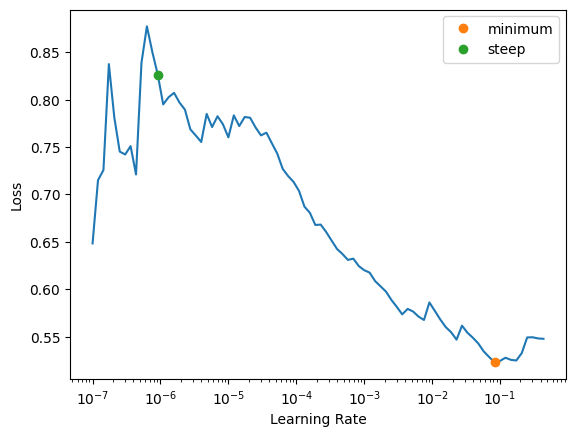

In [15]:
from fastai.tabular.all import tabular_learner

if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    # Learning rate finder
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

    # Train
    learn.fit_one_cycle(epochs, lr_max=3e-3)
    print("Model training complete")

    learn.export(modelFolder / f'{modelName}.pkl')

## Testing and benchmarking

In [16]:
def logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": modelName,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(test_tickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

In [17]:
def plotResults(filtered_df, model_name, model_folder):
    """Create and save visualization plots"""
    plt.figure(figsize=(12, 8))
    
    # Scatter plot
    plt.subplot(2, 1, 1)
    actuals = filtered_df['Actual']
    if actuals.var() == 0:
        r2 = 0  # Avoid division by zero
    else:
        r2 = 1 - (np.sum(filtered_df['Residual']**2) / np.sum((actuals - actuals.mean())**2))
        
    predictions = filtered_df['Predicted']
    plt.scatter(actuals, predictions, alpha=0.7, label='Predictions')
    
    # Perfect prediction line
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='red', linestyle='--', label='Perfect Prediction')
    
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns', fontsize=12)
    plt.ylabel('Predicted Returns', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.5)
    
    # Residual plot
    plt.subplot(2, 1, 2)
    plt.scatter(predictions, filtered_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot', fontsize=14)
    plt.xlabel('Predicted Returns', fontsize=12)
    plt.ylabel('Residual', fontsize=12)
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    
    # Show plot
    plt.show()

In [18]:
def evaluateModel(learn, test_tickers, model_name, model_folder, cont_names, cat_names):
    validTestTickers = []
    problematic_tickers = []  # Track tickers with NaN

    for ticker in test_tickers:
        test_data = getTickerDataFrom1YrAgo(ticker)
        if test_data.empty:
            continue
        # Check for NaN in EV/EBIT and ROIC
        if test_data[['EV/EBIT', 'ROIC']].isna().any().any():
            problematic_tickers.append(ticker)
            continue
        validTestTickers.append(test_data)

    if not validTestTickers:
        raise ValueError(f"No valid test data. Problematic tickers: {problematic_tickers}")

    combinedTestData = pd.concat(validTestTickers, ignore_index=True)
    test_dl = learn.dls.test_dl(combinedTestData)
    preds, targs = learn.get_preds(dl=test_dl)
    predictions = preds.numpy()
    actuals = targs.numpy()

    results_df = pd.DataFrame({
        'Predicted': predictions.flatten(),
        'Actual': actuals.flatten()
    })

    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']
    outlier_threshold = 2 * results_df['Residual'].std()
    filtered_df = results_df[abs(results_df['Residual']) <= outlier_threshold]

    mae = np.mean(np.abs(filtered_df['Residual']))
    rmse = np.sqrt(np.mean(filtered_df['Residual']**2))
    r2 = 1 - (np.sum(filtered_df['Residual']**2) / np.sum((filtered_df['Actual'] - filtered_df['Actual'].mean())**2))

    logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers)
    plotResults(filtered_df, model_name, model_folder)

    return mae, rmse, r2

In [19]:
test = getTickerDataFrom1YrAgo("NVO")
test.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Future Year Change,Industry,EV/EBIT,ROIC
0,2023-12-27 00:00:00-05:00,101.544553,102.682052,101.237916,102.553467,2254900.0,0.0,0.0,-0.142204,Drug Manufacturers - General,8.061929,0.097991


## Evaluate model

$GMCR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for GMCR: No historical data available for GMCR around 2024-01-26.


$PACQ: possibly delisted; no timezone found


Error fetching data for PACQ: No historical data available for PACQ around 2024-01-26.


$EQY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for EQY: No historical data available for EQY around 2024-01-26.


$BRK.A: possibly delisted; no timezone found


Error fetching data for BRK.A: No historical data available for BRK.A around 2024-01-26.


$AHL-PA: possibly delisted; no timezone found
$JGG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AHL-PA: No historical data available for AHL-PA around 2024-01-26.
Error fetching data for JGG: No historical data available for JGG around 2024-01-26.


$ARTC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ARTC: No historical data available for ARTC around 2024-01-26.


$OTEL: possibly delisted; no timezone found
$OPXA: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for OTEL: No historical data available for OTEL around 2024-01-26.
Error fetching data for OPXA: No historical data available for OPXA around 2024-01-26.


$DFRG: possibly delisted; no timezone found


Error fetching data for DFRG: No historical data available for DFRG around 2024-01-26.


$AXE: possibly delisted; no timezone found
$PACT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AXE: No historical data available for AXE around 2024-01-26.
Error fetching data for PACT: No historical data available for PACT around 2024-01-26.


$BOBE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$CXPO: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BOBE: No historical data available for BOBE around 2024-01-26.
Error fetching data for CXPO: No historical data available for CXPO around 2024-01-26.


$ADRE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$HSOL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$RLOG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ADRE: No historical data available for ADRE around 2024-01-26.
Error fetching data for HSOL: No historical data available for HSOL around 2024-01-26.
Error fetching data for RLOG: No historical data available for RLOG around 2024-01-26.


$ISBC: possibly delisted; no timezone found
$EEP: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$UTEK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ISBC: No historical data available for ISBC around 2024-01-26.
Error fetching data for EEP: No historical data available for EEP around 2024-01-26.
Error fetching data for UTEK: No historical data available for UTEK around 2024-01-26.


$CBMX: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$CBF: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CBMX: No historical data available for CBMX around 2024-01-26.
Error fetching data for CBF: No historical data available for CBF around 2024-01-26.


$ANH-A: possibly delisted; no timezone found


Error fetching data for ANH-A: No historical data available for ANH-A around 2024-01-26.


$HNH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HNH: No historical data available for HNH around 2024-01-26.


$XL: possibly delisted; no timezone found
$DGAS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for XL: No historical data available for XL around 2024-01-26.
Error fetching data for DGAS: No historical data available for DGAS around 2024-01-26.


$OHRP: possibly delisted; no timezone found


Error fetching data for OHRP: No historical data available for OHRP around 2024-01-26.


$PZE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$AMBT: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for PZE: No historical data available for PZE around 2024-01-26.
Error fetching data for AMBT: No historical data available for AMBT around 2024-01-26.


$NLY-D: possibly delisted; no timezone found


Error fetching data for NLY-D: No historical data available for NLY-D around 2024-01-26.


$DXPS: possibly delisted; no timezone found


Error fetching data for DXPS: No historical data available for DXPS around 2024-01-26.


$EMES: possibly delisted; no timezone found


Error fetching data for EMES: No historical data available for EMES around 2024-01-26.


$PGRX: possibly delisted; no timezone found


Error fetching data for PGRX: No historical data available for PGRX around 2024-01-26.


$METR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for METR: No historical data available for METR around 2024-01-26.


$CQB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for CQB: No historical data available for CQB around 2024-01-26.


$HAYN: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26) (Yahoo error = "No data found, symbol may be delisted")
$GY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HAYN: No historical data available for HAYN around 2024-01-26.
Error fetching data for GY: No historical data available for GY around 2024-01-26.


$BGCA: possibly delisted; no timezone found
$OSTK: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for BGCA: No historical data available for BGCA around 2024-01-26.
Error fetching data for OSTK: No historical data available for OSTK around 2024-01-26.


$TRNX: possibly delisted; no timezone found


Error fetching data for TRNX: No historical data available for TRNX around 2024-01-26.


$GFN: possibly delisted; no timezone found


Error fetching data for GFN: No historical data available for GFN around 2024-01-26.


$FUR-D: possibly delisted; no timezone found


Error fetching data for FUR-D: No historical data available for FUR-D around 2024-01-26.


$ISLE: possibly delisted; no timezone found


Error fetching data for ISLE: No historical data available for ISLE around 2024-01-26.


$NCS: possibly delisted; no timezone found


Error fetching data for NCS: No historical data available for NCS around 2024-01-26.


$HPP-B: possibly delisted; no timezone found


Error fetching data for HPP-B: No historical data available for HPP-B around 2024-01-26.


$HBK: possibly delisted; no timezone found


Error fetching data for HBK: No historical data available for HBK around 2024-01-26.


$NMY-D: possibly delisted; no timezone found


Error fetching data for NMY-D: No historical data available for NMY-D around 2024-01-26.


$OZM: possibly delisted; no timezone found
$IND: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for OZM: No historical data available for OZM around 2024-01-26.
Error fetching data for IND: No historical data available for IND around 2024-01-26.


$CISAU: possibly delisted; no timezone found


Error fetching data for CISAU: No historical data available for CISAU around 2024-01-26.


$CSII: possibly delisted; no timezone found


Error fetching data for CSII: No historical data available for CSII around 2024-01-26.


$BRS: possibly delisted; no timezone found


Error fetching data for BRS: No historical data available for BRS around 2024-01-26.


$CETV: possibly delisted; no timezone found


Error fetching data for CETV: No historical data available for CETV around 2024-01-26.


$NTC-E: possibly delisted; no timezone found


Error fetching data for NTC-E: No historical data available for NTC-E around 2024-01-26.


$DAEG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for DAEG: No historical data available for DAEG around 2024-01-26.


$TCB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TCB: No historical data available for TCB around 2024-01-26.


$MEILW: possibly delisted; no timezone found


Error fetching data for MEILW: No historical data available for MEILW around 2024-01-26.


$SFI-D: possibly delisted; no timezone found


Error fetching data for SFI-D: No historical data available for SFI-D around 2024-01-26.


$LPR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for LPR: No historical data available for LPR around 2024-01-26.


$GRA: possibly delisted; no timezone found


Error fetching data for GRA: No historical data available for GRA around 2024-01-26.


$NSL: possibly delisted; no timezone found


Error fetching data for NSL: No historical data available for NSL around 2024-01-26.


$AOL: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AOL: No historical data available for AOL around 2024-01-26.


$ECTY: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ECTY: No historical data available for ECTY around 2024-01-26.


$SWJ: possibly delisted; no timezone found


Error fetching data for SWJ: No historical data available for SWJ around 2024-01-26.


$SB-B: possibly delisted; no timezone found


Error fetching data for SB-B: No historical data available for SB-B around 2024-01-26.


$SAL: possibly delisted; no timezone found


Error fetching data for SAL: No historical data available for SAL around 2024-01-26.


$MMP: possibly delisted; no timezone found


Error fetching data for MMP: No historical data available for MMP around 2024-01-26.


$JPM.W: possibly delisted; no timezone found
$MSCC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for JPM.W: No historical data available for JPM.W around 2024-01-26.
Error fetching data for MSCC: No historical data available for MSCC around 2024-01-26.


$NPV-A: possibly delisted; no timezone found
$APRI: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NPV-A: No historical data available for NPV-A around 2024-01-26.
Error fetching data for APRI: No historical data available for APRI around 2024-01-26.


$RBS-T: possibly delisted; no timezone found


Error fetching data for RBS-T: No historical data available for RBS-T around 2024-01-26.


$SAN-I: possibly delisted; no timezone found


Error fetching data for SAN-I: No historical data available for SAN-I around 2024-01-26.


$CYS-B: possibly delisted; no timezone found


Error fetching data for CYS-B: No historical data available for CYS-B around 2024-01-26.


$NRF-C: possibly delisted; no timezone found


Error fetching data for NRF-C: No historical data available for NRF-C around 2024-01-26.


$FULLL: possibly delisted; no timezone found
$YONG: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$CRDC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for FULLL: No historical data available for FULLL around 2024-01-26.
Error fetching data for YONG: No historical data available for YONG around 2024-01-26.
Error fetching data for CRDC: No historical data available for CRDC around 2024-01-26.


$HNR: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for HNR: No historical data available for HNR around 2024-01-26.


$CWH-D: possibly delisted; no timezone found


Error fetching data for CWH-D: No historical data available for CWH-D around 2024-01-26.


$TMS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for TMS: No historical data available for TMS around 2024-01-26.


$AINV: possibly delisted; no timezone found


Error fetching data for AINV: No historical data available for AINV around 2024-01-26.


$NTLS: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$HIH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for NTLS: No historical data available for NTLS around 2024-01-26.
Error fetching data for HIH: No historical data available for HIH around 2024-01-26.


$UBIC: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for UBIC: No historical data available for UBIC around 2024-01-26.


$FBC: possibly delisted; no timezone found


Error fetching data for FBC: No historical data available for FBC around 2024-01-26.


$SPN: possibly delisted; no timezone found


Error fetching data for SPN: No historical data available for SPN around 2024-01-26.


$SAPE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$FCH: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for SAPE: No historical data available for SAPE around 2024-01-26.
Error fetching data for FCH: No historical data available for FCH around 2024-01-26.


$AEV: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for AEV: No historical data available for AEV around 2024-01-26.


$ANCB: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)
$DATE: possibly delisted; no price data found  (1d 2023-12-27 -> 2024-01-26)


Error fetching data for ANCB: No historical data available for ANCB around 2024-01-26.
Error fetching data for Date: No historical data available for Date around 2024-01-26.


$CLOSE: possibly delisted; no timezone found


Error fetching data for Close: No historical data available for Close around 2024-01-26.


$VOLUME: possibly delisted; no timezone found


Error fetching data for Volume: No historical data available for Volume around 2024-01-26.


$DIVIDENDS: possibly delisted; no timezone found


Error fetching data for Dividends: No historical data available for Dividends around 2024-01-26.


$STOCK SPLITS: possibly delisted; no timezone found


Error fetching data for Stock Splits: No historical data available for Stock Splits around 2024-01-26.


$FUTURE YEAR CHANGE: possibly delisted; no timezone found


Error fetching data for Future Year Change: No historical data available for Future Year Change around 2024-01-26.


$INDUSTRY: possibly delisted; no timezone found


Error fetching data for Industry: No historical data available for Industry around 2024-01-26.


Failed to get ticker 'EV/EBIT' reason: Expecting value: line 1 column 1 (char 0)
$EV/EBIT: possibly delisted; no timezone found


Error fetching data for EV/EBIT: No historical data available for EV/EBIT around 2024-01-26.


Logged evaluation results to c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\TrainedModels\stockScreener\modelEvaluations.csv


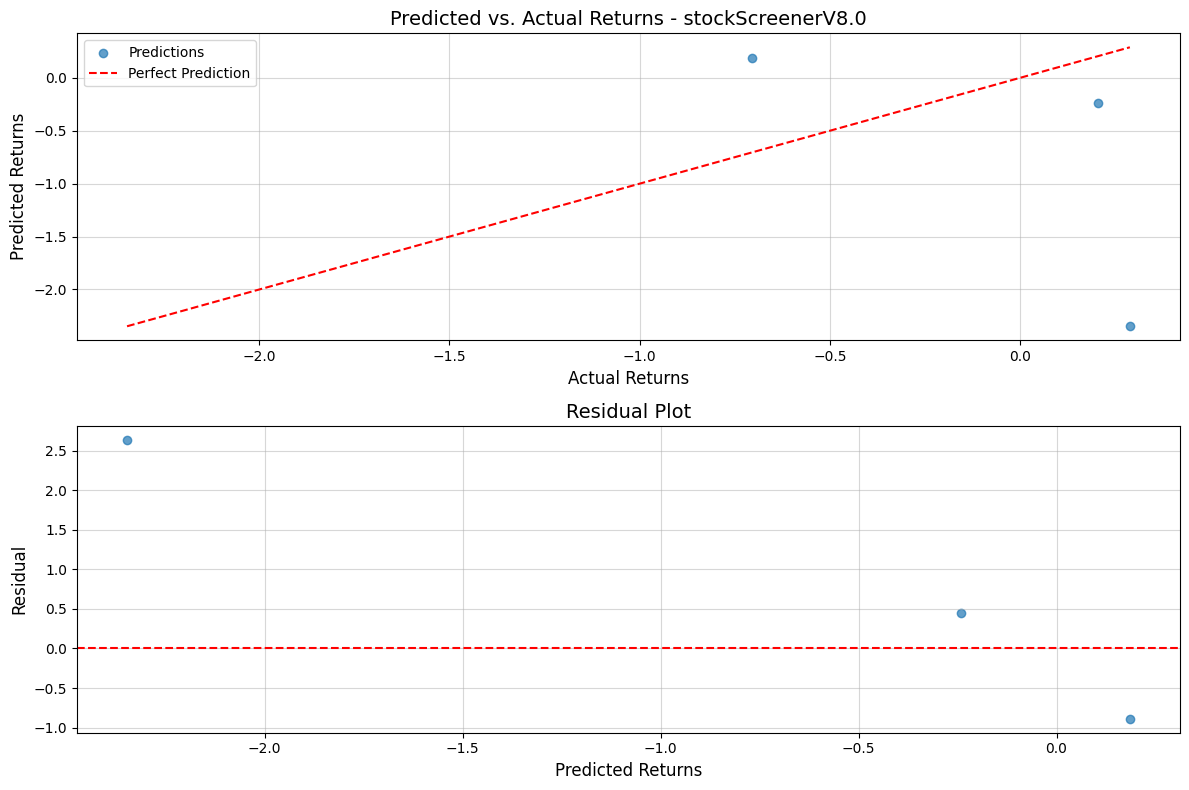

Amount of test tickers: 61, Expected: 175
Evaluation Results:
MAE: 1.323
RMSE: 1.627
R2: -12.121


In [20]:
if trainNewModel:
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    validTestTickers = []
    
    # Iterate through available non-training tickers (up to testSize)
    for ticker in nonTrainingTickers[:testSize]:
        testData = getTickerDataFrom1YrAgo(ticker)
        if not testData.empty and not testData[['EV/EBIT', 'ROIC']].isna().any().any():
            validTestTickers.append(testData)
    
    if not validTestTickers:
        raise ValueError("No valid test data collected. Ensure testTickers have valid EV/EBIT and ROIC data.")
    
    combinedTestData = pd.concat(validTestTickers, ignore_index=True)

    mae, rmse, r2 = evaluateModel(
        learn=learn,
        test_tickers=combinedTestData,
        model_name=modelName,
        model_folder=modelFolder,
        cont_names=contNames,
        cat_names=catNames
    )

    print(f"Amount of test tickers: {len(combinedTestData)}, Expected: {testSize}")

    if mae is not None and rmse is not None and r2 is not None:
        print(f"Evaluation Results:")
        print(f"MAE: {mae:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"R2: {r2:.3f}")
    else:
        print("Evaluation failed. Metrics are None.")

## Tests

In [21]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV1.0.pkl
stockScreenerV2.0.pkl
stockScreenerV3.0.pkl
stockScreenerV4.0.pkl
stockScreenerV4.1.pkl
stockScreenerV5.0.pkl
stockScreenerV5.1.pkl
stockScreenerV5.2.pkl
stockScreenerV5.3.pkl
stockScreenerV5.4.pkl
stockScreenerV6.0.pkl
stockScreenerV8.0.pkl


In [22]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV5.0
Timestamp      2025-01-21 21:03
MAE                       0.237
RMSE                      0.302
R2                       -0.002
Name: 5, dtype: object

### Load model

In [23]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
else:
    pathlib.WindowsPath = pathlib.PosixPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

## Predictions

In [24]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

predictionTarget = '8%'

Prediction for NVO (Novo Nordisk A/S):
51.46%
Free money?!
